# Wikipedia Indexing with ColBERT

In [4]:
# conda install polars pandas seaborn tqdm -c conda-forge
# !pip install rank_bm25
# !pip install -e './ColBERT'

  Using cached rank_bm25-0.2.2-py3-none-any.whl (8.6 kB)


In [6]:
# conda upgrade numpy -c conda-forge
# # conda install -c conda-forge faiss-gpu

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'garbage_collection_threshold:0.6,max_split_size_mb:128'
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
import faiss

from rank_bm25 import BM25Okapi
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection
from colbert import Indexer, Searcher

In [2]:
pl.Config(fmt_str_lengths=2000);

In [3]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia -y

In [4]:
#!pip install rank_bm25

In [5]:
# !conda list | grep bitsandbytes

In [6]:
# !conda install -c conda-forge pyarrow -y

In [7]:
# !conda update -c conda-forge 'auto-gptq[triton]' -y

In [8]:
# huggingface_hub.login(os.environ['HUGGING_FACE_TOKEN'])

In [9]:
questions = pl.read_parquet('./data/daniel_train/v_1_combined/daniel_train_v_1.parquet')
questions = questions.filter(pl.col('question').is_not_null())
questions.shape, np.array(questions.columns)

((5799, 8),
 array(['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3',
        'incorrect_4', 'title', 'section_title'], dtype='<U13'))

In [10]:
wiki_sections = pl.read_parquet('./data/wiki_with_category_v_4.parquet')
section_word_counts = wiki_sections['section_text'].str.split(' ').list.lengths()
wiki_sections = wiki_sections.with_columns(section_word_count=pl.Series(section_word_counts))

wiki_sections = wiki_sections.filter(pl.col('section_word_count') > 11)
wiki_sections.shape, np.array(wiki_sections.columns) # 833,300 sections

((827713, 16),
 array(['section_id', 'title', 'category', 'page_id', 'parent_id',
        'revision_id', 'revision_ts', 'short_description', 'sha1',
        'page_bytes', 'section_index', 'section_title', 'section_level',
        'section_text', 'title_section_rank', 'section_word_count'],
       dtype='<U18'))

In [11]:
wiki_sections['title'].n_unique()

154105

'Mean word count: 207, median: 120'

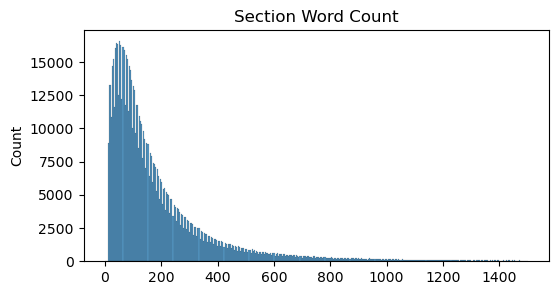

In [12]:
plt.figure(figsize=[6,3])
sns.histplot(wiki_sections['section_word_count'], binrange=[0, 1500])
plt.title('Section Word Count')
f'Mean word count: {section_word_counts.mean():.0f}, median: {section_word_counts.median():.0f}'

In [13]:
wiki_sections.filter(pl.col('title').str.starts_with('List of'))

section_id,title,category,page_id,parent_id,revision_id,revision_ts,short_description,sha1,page_bytes,section_index,section_title,section_level,section_text,title_section_rank,section_word_count
u32,str,str,i64,i64,i64,datetime[μs],str,str,i64,i64,str,i64,str,u32,u32


In [14]:
# wiki_sections.sample(20)[['title', 'section_title', 'section_text']]

In [15]:
# with pl.Config() as cfg:
#     cfg.set_tbl_rows(100)
#     display(wiki_sections.filter(pl.col('section_word_count') < 15)[['title', 'section_title', 'section_text']])

In [16]:
max_words = 200
doc_maxlen = 320
query_maxlen = 320
nbits = 1
colbert_path = Path(f'./data/colbert_max_words_{max_words}_nbits_{nbits}-v6')
os.makedirs(colbert_path, exist_ok=True)

In [17]:
def split_text_into_chunks(row):
    text = row[4]
    title = row[1]
    section_title = row[2]
    n_titles_words = len(title.split(' ')) + len(section_title.split(' '))
    
    chunks = []
    current_chunk = []
    current_length = 0
    last_period = -1
    section_words = text.split()

    remaining_words = list(section_words)
    split_sum = 0
    for word in section_words:
        current_length += 1
        if word.endswith('.'):
            last_period = current_length
        
        if current_length == max_words - n_titles_words:
            if last_period > -1:
                chunk = remaining_words[:last_period]
                chunks.append(" ".join(chunk))
                remaining_words = remaining_words[last_period:]             
                current_length = current_length - last_period
                split_sum += last_period
            else:
                # If no period exists, just split it at max_words
                chunk = remaining_words[:current_length]
                chunks.append(" ".join(chunk))
                remaining_words = remaining_words[current_length:]
                current_length = 0
                split_sum += current_length
            last_period = -1

    if remaining_words:
        chunks.append(" ".join(remaining_words))
    
    return (chunks,)


sel_sections = wiki_sections[['section_id', 'title', 'section_title', 'section_index', 'section_text']]
# \s: Matches any whitespace character, including spaces, tabs, and newline characters.
# \S: Matches any character that is NOT a whitespace character.
sel_sections = sel_sections.with_columns(pl.col('section_text').str.replace_all('\n', ' '))
sel_sections = sel_sections.with_columns(pl.col('section_title').str.replace_all('<ref[^>]*>[\s\S]*?<\/ref>', ''))
sel_sections = sel_sections.with_columns(pl.col('section_title').str.replace_all('<!--.*-->', ''))
sel_sections = sel_sections.with_columns(pl.col('section_title').str.replace_all('\{\{anchor.*\}\}', ''))
sel_sections = sel_sections.with_columns(pl.col('section_title').str.replace_all('\{\{efn-ua.*\}\}', ''))
sel_sections = sel_sections.with_columns(pl.col('section_text').str.replace_all('<ref[^>]*>[\s\S]*?<\/ref>', ''))
passage_chunks = sel_sections.map_rows(split_text_into_chunks, return_dtype=pl.List(pl.Utf8))
passage_chunks = passage_chunks.rename({'column_0': 'passage_text'})

passages = sel_sections.with_columns(passage_chunks)
passages = passages.drop('section_text')
passages = passages.explode('passage_text')

passages = passages.with_columns(pl.col('title')\
                   .rank(method="ordinal")\
                   .over(['title', 'section_index', 'section_title', 'passage_text'])\
                   .alias('title_section_rank'))
passages = passages.filter(pl.col('title_section_rank') == 1)
passages = passages.filter(pl.col('passage_text').is_not_null())\
                   .with_row_count('passage_id')
                      
passages = passages.with_columns(pl.col('passage_id').rank(method="min").over(["section_id"]).alias('section_passage_num'))

passages = passages.with_columns(titled_passage=pl.col('title') +\
                                  ': ' + pl.col('section_title') + ': '\
                                  + pl.col('passage_text').str.replace_all(r"[\n\t]+$", ""))
passages = passages.with_columns(word_count=passages['titled_passage'].str.split(' ').list.lengths())

passages_file = colbert_path/'wiki_passages'
passages.write_parquet(str(passages_file) +'.parquet')

passages.shape, passages.columns # 2,500,725 of max_words 100

((1406593, 10),
 ['passage_id',
  'section_id',
  'title',
  'section_title',
  'section_index',
  'passage_text',
  'title_section_rank',
  'section_passage_num',
  'titled_passage',
  'word_count'])

In [18]:
passages.filter(pl.col('word_count') > max_words).shape[0]

0

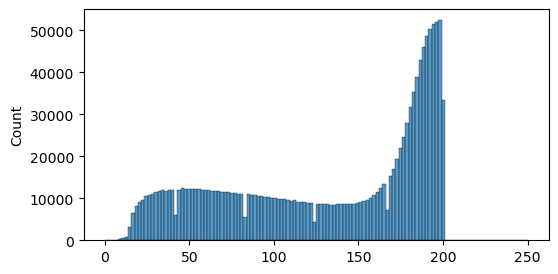

In [19]:
plt.figure(figsize=[6,3])
sns.histplot(passages['titled_passage'].str.split(' ').list.lengths(), binrange=[0, max_words + 50]);

## Using ColBERT to find Wiki Section

In [20]:
passages_file = colbert_path/'wiki_passages'
passages[['passage_id', 'titled_passage']].write_csv(str(passages_file) + '.tsv', separator='\t', has_header=False)

In [21]:
checkpoint = './checkpoints/colbertv2.0'
indexer_name = f"colbert_wiki_indexer"

c_collection = Collection(str(passages_file) + '.tsv')
f'Loaded {len(c_collection):,} passages'

os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    query_maxlen=query_maxlen, 
    nbits=nbits
)

[Oct 08, 13:22:35] #> Loading collection...
0M 1M 


In [32]:
rerun = True
if rerun:
    with Run().context(RunConfig(nranks=1, index_root=str(colbert_path))):
        indexer = Indexer(checkpoint=checkpoint, config=config)
        indexer.index(name=indexer_name,
                      collection=c_collection,
                      overwrite=True)



[Oct 08, 12:02:02] #> Creating directory data/colbert_max_words_200_nbits_1-v6/colbert_wiki_indexer 


#> Starting...
nranks = 1 	 num_gpus = 1 	 device=0
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "index_path": null,
    "nbits": 1,
    "kmeans_niters": 20,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_negatives": true,
    "reranker": false,
    "distillation_alpha": 1.0,
    "ignore_scores": false,
    "model_name": null,
    "query_maxlen": 320,
    "attend_to_mask_tokens": false,
    "interaction": "colbert",
    "dim": 128,
    "doc_maxlen": 320,
    "mask_punctuation": true,
    "checkpoint": ".\/checkpoints\/colbertv2.0",
    

Using /home/daniel/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/daniel/.cache/torch_extensions/py311_cu121/decompress_residuals_cpp/build.ninja...
Building extension module decompress_residuals_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module decompress_residuals_cpp...
Using /home/daniel/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/daniel/.cache/torch_extensions/py311_cu121/packbits_cpp/build.ninja...
Building extension module packbits_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module packbits_cpp...
0it [00:00, ?it/s]

[Oct 08, 12:26:46] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:27:19] [0] 		 #> Saving chunk 0: 	 25,000 passages and 4,158,872 embeddings. From #0 onward.


1it [00:36, 36.63s/it]

[Oct 08, 12:27:22] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:27:56] [0] 		 #> Saving chunk 1: 	 25,000 passages and 4,293,549 embeddings. From #25,000 onward.


2it [01:13, 36.75s/it]

[Oct 08, 12:27:59] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:28:33] [0] 		 #> Saving chunk 2: 	 25,000 passages and 4,205,012 embeddings. From #50,000 onward.


3it [01:50, 36.70s/it]

[Oct 08, 12:28:36] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:29:10] [0] 		 #> Saving chunk 3: 	 25,000 passages and 4,192,060 embeddings. From #75,000 onward.


4it [02:26, 36.67s/it]

[Oct 08, 12:29:12] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:29:46] [0] 		 #> Saving chunk 4: 	 25,000 passages and 4,234,737 embeddings. From #100,000 onward.


5it [03:03, 36.66s/it]

[Oct 08, 12:29:49] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:30:23] [0] 		 #> Saving chunk 5: 	 25,000 passages and 4,208,431 embeddings. From #125,000 onward.


6it [03:40, 36.67s/it]

[Oct 08, 12:30:26] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:30:59] [0] 		 #> Saving chunk 6: 	 25,000 passages and 4,240,751 embeddings. From #150,000 onward.


7it [04:16, 36.67s/it]

[Oct 08, 12:31:02] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:31:36] [0] 		 #> Saving chunk 7: 	 25,000 passages and 4,172,549 embeddings. From #175,000 onward.


8it [04:53, 36.69s/it]

[Oct 08, 12:31:39] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:32:13] [0] 		 #> Saving chunk 8: 	 25,000 passages and 4,263,682 embeddings. From #200,000 onward.


9it [05:30, 36.69s/it]

[Oct 08, 12:32:16] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:32:50] [0] 		 #> Saving chunk 9: 	 25,000 passages and 4,161,079 embeddings. From #225,000 onward.


10it [06:06, 36.66s/it]

[Oct 08, 12:32:52] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:33:26] [0] 		 #> Saving chunk 10: 	 25,000 passages and 4,202,638 embeddings. From #250,000 onward.


11it [06:43, 36.66s/it]

[Oct 08, 12:33:29] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:34:03] [0] 		 #> Saving chunk 11: 	 25,000 passages and 4,234,372 embeddings. From #275,000 onward.


12it [07:20, 36.70s/it]

[Oct 08, 12:34:06] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:34:40] [0] 		 #> Saving chunk 12: 	 25,000 passages and 4,215,905 embeddings. From #300,000 onward.


13it [07:56, 36.69s/it]

[Oct 08, 12:34:42] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:35:16] [0] 		 #> Saving chunk 13: 	 25,000 passages and 4,217,180 embeddings. From #325,000 onward.


14it [08:33, 36.68s/it]

[Oct 08, 12:35:19] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:35:53] [0] 		 #> Saving chunk 14: 	 25,000 passages and 4,188,177 embeddings. From #350,000 onward.


15it [09:10, 36.67s/it]

[Oct 08, 12:35:56] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:36:30] [0] 		 #> Saving chunk 15: 	 25,000 passages and 4,254,548 embeddings. From #375,000 onward.


16it [09:46, 36.70s/it]

[Oct 08, 12:36:32] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:37:07] [0] 		 #> Saving chunk 16: 	 25,000 passages and 4,173,270 embeddings. From #400,000 onward.


17it [10:23, 36.73s/it]

[Oct 08, 12:37:09] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:37:43] [0] 		 #> Saving chunk 17: 	 25,000 passages and 4,212,548 embeddings. From #425,000 onward.


18it [11:00, 36.72s/it]

[Oct 08, 12:37:46] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:38:20] [0] 		 #> Saving chunk 18: 	 25,000 passages and 4,223,027 embeddings. From #450,000 onward.


19it [11:37, 36.71s/it]

[Oct 08, 12:38:23] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:38:57] [0] 		 #> Saving chunk 19: 	 25,000 passages and 4,236,843 embeddings. From #475,000 onward.


20it [12:13, 36.72s/it]

[Oct 08, 12:38:59] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:39:33] [0] 		 #> Saving chunk 20: 	 25,000 passages and 4,206,620 embeddings. From #500,000 onward.


21it [12:50, 36.70s/it]

[Oct 08, 12:39:36] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:40:10] [0] 		 #> Saving chunk 21: 	 25,000 passages and 4,165,586 embeddings. From #525,000 onward.


22it [13:27, 36.67s/it]

[Oct 08, 12:40:13] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:40:47] [0] 		 #> Saving chunk 22: 	 25,000 passages and 4,262,444 embeddings. From #550,000 onward.


23it [14:03, 36.70s/it]

[Oct 08, 12:40:49] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:41:23] [0] 		 #> Saving chunk 23: 	 25,000 passages and 4,188,069 embeddings. From #575,000 onward.


24it [14:40, 36.67s/it]

[Oct 08, 12:41:26] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:42:00] [0] 		 #> Saving chunk 24: 	 25,000 passages and 4,217,759 embeddings. From #600,000 onward.


25it [15:17, 36.67s/it]

[Oct 08, 12:42:03] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:42:37] [0] 		 #> Saving chunk 25: 	 25,000 passages and 4,215,096 embeddings. From #625,000 onward.


26it [15:53, 36.65s/it]

[Oct 08, 12:42:39] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:43:13] [0] 		 #> Saving chunk 26: 	 25,000 passages and 4,226,934 embeddings. From #650,000 onward.


27it [16:30, 36.68s/it]

[Oct 08, 12:43:16] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:43:50] [0] 		 #> Saving chunk 27: 	 25,000 passages and 4,205,826 embeddings. From #675,000 onward.


28it [17:07, 36.66s/it]

[Oct 08, 12:43:53] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:44:27] [0] 		 #> Saving chunk 28: 	 25,000 passages and 4,196,260 embeddings. From #700,000 onward.


29it [17:43, 36.65s/it]

[Oct 08, 12:44:29] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:45:03] [0] 		 #> Saving chunk 29: 	 25,000 passages and 4,270,159 embeddings. From #725,000 onward.


30it [18:20, 36.66s/it]

[Oct 08, 12:45:06] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:45:40] [0] 		 #> Saving chunk 30: 	 25,000 passages and 4,177,962 embeddings. From #750,000 onward.


31it [18:57, 36.64s/it]

[Oct 08, 12:45:43] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:46:16] [0] 		 #> Saving chunk 31: 	 25,000 passages and 4,248,241 embeddings. From #775,000 onward.


32it [19:33, 36.65s/it]

[Oct 08, 12:46:19] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:46:53] [0] 		 #> Saving chunk 32: 	 25,000 passages and 4,204,315 embeddings. From #800,000 onward.


33it [20:10, 36.68s/it]

[Oct 08, 12:46:56] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:47:30] [0] 		 #> Saving chunk 33: 	 25,000 passages and 4,254,175 embeddings. From #825,000 onward.


34it [20:47, 36.68s/it]

[Oct 08, 12:47:33] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:48:07] [0] 		 #> Saving chunk 34: 	 25,000 passages and 4,180,464 embeddings. From #850,000 onward.


35it [21:23, 36.66s/it]

[Oct 08, 12:48:09] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:48:43] [0] 		 #> Saving chunk 35: 	 25,000 passages and 4,206,747 embeddings. From #875,000 onward.


36it [22:00, 36.66s/it]

[Oct 08, 12:48:46] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:49:20] [0] 		 #> Saving chunk 36: 	 25,000 passages and 4,269,341 embeddings. From #900,000 onward.


37it [22:37, 36.70s/it]

[Oct 08, 12:49:23] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:49:57] [0] 		 #> Saving chunk 37: 	 25,000 passages and 4,188,732 embeddings. From #925,000 onward.


38it [23:13, 36.67s/it]

[Oct 08, 12:49:59] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:50:33] [0] 		 #> Saving chunk 38: 	 25,000 passages and 4,202,096 embeddings. From #950,000 onward.


39it [23:50, 36.66s/it]

[Oct 08, 12:50:36] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:51:10] [0] 		 #> Saving chunk 39: 	 25,000 passages and 4,234,424 embeddings. From #975,000 onward.


40it [24:27, 36.65s/it]

[Oct 08, 12:51:13] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:51:46] [0] 		 #> Saving chunk 40: 	 25,000 passages and 4,229,634 embeddings. From #1,000,000 onward.


41it [25:03, 36.65s/it]

[Oct 08, 12:51:49] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:52:23] [0] 		 #> Saving chunk 41: 	 25,000 passages and 4,205,006 embeddings. From #1,025,000 onward.


42it [25:40, 36.67s/it]

[Oct 08, 12:52:26] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:53:00] [0] 		 #> Saving chunk 42: 	 25,000 passages and 4,224,915 embeddings. From #1,050,000 onward.


43it [26:17, 36.66s/it]

[Oct 08, 12:53:03] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:53:37] [0] 		 #> Saving chunk 43: 	 25,000 passages and 4,301,484 embeddings. From #1,075,000 onward.


44it [26:53, 36.68s/it]

[Oct 08, 12:53:39] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:54:13] [0] 		 #> Saving chunk 44: 	 25,000 passages and 4,181,204 embeddings. From #1,100,000 onward.


45it [27:30, 36.66s/it]

[Oct 08, 12:54:16] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:54:50] [0] 		 #> Saving chunk 45: 	 25,000 passages and 4,232,669 embeddings. From #1,125,000 onward.


46it [28:07, 36.66s/it]

[Oct 08, 12:54:53] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:55:27] [0] 		 #> Saving chunk 46: 	 25,000 passages and 4,229,224 embeddings. From #1,150,000 onward.


47it [28:43, 36.69s/it]

[Oct 08, 12:55:29] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:56:03] [0] 		 #> Saving chunk 47: 	 25,000 passages and 4,225,504 embeddings. From #1,175,000 onward.


48it [29:20, 36.67s/it]

[Oct 08, 12:56:06] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:56:40] [0] 		 #> Saving chunk 48: 	 25,000 passages and 4,205,582 embeddings. From #1,200,000 onward.


49it [29:57, 36.66s/it]

[Oct 08, 12:56:43] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:57:17] [0] 		 #> Saving chunk 49: 	 25,000 passages and 4,210,998 embeddings. From #1,225,000 onward.


50it [30:33, 36.65s/it]

[Oct 08, 12:57:19] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:57:53] [0] 		 #> Saving chunk 50: 	 25,000 passages and 4,257,833 embeddings. From #1,250,000 onward.


51it [31:10, 36.67s/it]

[Oct 08, 12:57:56] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:58:30] [0] 		 #> Saving chunk 51: 	 25,000 passages and 4,245,689 embeddings. From #1,275,000 onward.


52it [31:47, 36.70s/it]

[Oct 08, 12:58:33] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:59:07] [0] 		 #> Saving chunk 52: 	 25,000 passages and 4,248,860 embeddings. From #1,300,000 onward.


53it [32:23, 36.69s/it]

[Oct 08, 12:59:09] [0] 		 #> Encoding 25000 passages..
[Oct 08, 12:59:43] [0] 		 #> Saving chunk 53: 	 25,000 passages and 4,195,042 embeddings. From #1,325,000 onward.


54it [33:00, 36.67s/it]

[Oct 08, 12:59:46] [0] 		 #> Encoding 25000 passages..
[Oct 08, 13:00:20] [0] 		 #> Saving chunk 54: 	 25,000 passages and 4,193,262 embeddings. From #1,350,000 onward.


55it [33:37, 36.65s/it]

[Oct 08, 13:00:23] [0] 		 #> Encoding 25000 passages..
[Oct 08, 13:00:57] [0] 		 #> Saving chunk 55: 	 25,000 passages and 4,232,498 embeddings. From #1,375,000 onward.


56it [34:13, 36.65s/it]

[Oct 08, 13:00:59] [0] 		 #> Encoding 6593 passages..
[Oct 08, 13:01:08] [0] 		 #> Saving chunk 56: 	 6,593 passages and 1,161,044 embeddings. From #1,400,000 onward.


57it [34:23, 36.20s/it]


[Oct 08, 13:01:09] [0] 		 #> Checking all files were saved...
[Oct 08, 13:01:09] [0] 		 Found all files!
[Oct 08, 13:01:09] [0] 		 #> Building IVF...
[Oct 08, 13:01:09] [0] 		 #> Loading codes...


100%|██████████| 57/57 [00:00<00:00, 205.44it/s]


[Oct 08, 13:01:10] [0] 		 Sorting codes...
[Oct 08, 13:01:14] [0] 		 Getting unique codes...
[Oct 08, 13:01:15] #> Optimizing IVF to store map from centroids to list of pids..
[Oct 08, 13:01:15] #> Building the emb2pid mapping..
[Oct 08, 13:01:16] len(emb2pid) = 237390928


100%|██████████| 131072/131072 [00:12<00:00, 10353.77it/s]


[Oct 08, 13:01:30] #> Saved optimized IVF to data/colbert_max_words_200_nbits_1-v6/colbert_wiki_indexer/ivf.pid.pt
[Oct 08, 13:01:30] [0] 		 #> Saving the indexing metadata to data/colbert_max_words_200_nbits_1-v6/colbert_wiki_indexer/metadata.json ..
#> Joined...


## Search for known sections

In [22]:
n_questions = 500
queries = questions.with_row_count('qid')[['qid', 'question']]
queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' '))[:n_questions]
queries_file = './data/wiki_queries.tsv'
queries.write_csv(queries_file, separator='\t', has_header=False)
c_queries = Queries(queries_file)
f'Loaded {len(c_queries)} queries'

[Oct 08, 13:22:36] #> Loading the queries from ./data/wiki_queries.tsv ...
[Oct 08, 13:22:36] #> Got 500 queries. All QIDs are unique.



'Loaded 500 queries'

In [23]:
n_results_per_question = 3

with Run().context(RunConfig(nranks=1, index_root=str(colbert_path))):
    searcher = Searcher(index=indexer_name, config=config)
    ranking = searcher.search_all(c_queries, k=n_results_per_question)

[Oct 08, 13:22:36] #> Loading collection...
0M 1M 
[Oct 08, 13:22:39] #> Loading codec...
[Oct 08, 13:22:39] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


Using /home/daniel/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/daniel/.cache/torch_extensions/py311_cu121/decompress_residuals_cpp/build.ninja...
Building extension module decompress_residuals_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
[Oct 08, 13:22:39] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


Loading extension module decompress_residuals_cpp...
Using /home/daniel/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/daniel/.cache/torch_extensions/py311_cu121/packbits_cpp/build.ninja...
Building extension module packbits_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
[Oct 08, 13:22:39] #> Loading IVF...


Loading extension module packbits_cpp...


[Oct 08, 13:22:39] #> Loading doclens...


100%|██████████| 57/57 [00:00<00:00, 2902.32it/s]

[Oct 08, 13:22:39] #> Loading codes and residuals...



100%|██████████| 500/500 [00:17<00:00, 28.97it/s]


In [24]:
colbert = [tup[1] for tup in ranking.flat_ranking]
colbert = pl.Series("colbert", colbert[:n_questions * n_results_per_question], dtype=pl.UInt32)

## BM25

In [25]:
rerun_bm25 = False

def bm25_scores(query):
    tokenized_query = query.split(" ")
    scores = pd.Series(bm25_corpus.get_scores(tokenized_query))
    scores = scores.sort_values(ascending=False)
    return scores


file_path = Path('./data/bm25_scores.parquet')
if file_path.exists() and not rerun_bm25:
    bm25_res = pl.read_parquet(file_path)
else:
    tokenized_corpus = [doc.split(" ") for doc in passages['titled_passage']]
    bm25_corpus = BM25Okapi(tokenized_corpus)
    scores = []
    for question in tqdm(questions['question'][:n_questions]):
        q_scores = pd.Series(bm25_scores(question))
        top_10 = q_scores.sort_values(ascending=False)[:n_results_per_question].index.to_list()
        scores.append(top_10)

    bm25_res = pl.Series("bm25", scores, dtype=pl.List(pl.UInt32))
    bm25_res = questions[:n_questions][['question', 'title', 'section_title']].with_columns(bm25_res)
    bm25_res = bm25_res.with_row_count('qid')
    bm25_res = bm25_res.explode('bm25')
    bm25_res = bm25_res.with_columns(pl.lit(1).alias("ones"))\
                       .select([
                           pl.all().exclude("ones"),
                           pl.col("ones").cumsum().over("qid").flatten().alias("result_idx")
                       ])
    bm25_res = bm25_res.join(passages, how='left', left_on='bm25', right_on='passage_id', suffix='_bm25', validate='m:1')
    bm25_res.write_parquet(file_path)

### Precision

In [26]:
colbert_col = [tup[1] for tup in ranking.flat_ranking]
colbert_col = pl.Series("colbert", colbert[:n_questions * n_results_per_question], dtype=pl.UInt32)
res = bm25_res.with_columns(colbert_col)
res = res.join(passages, how='left', left_on='colbert', right_on='passage_id', validate='m:1', suffix='_col')
res = res.with_columns([
    (pl.col('title') == pl.col('title_bm25')).alias('bm25_title_match'),
    (pl.col('title') == pl.col('title_col')).alias('col_title_match')
])

In [27]:
res.filter(pl.col('result_idx') == 1)['bm25_title_match'].mean() # 100 words 0.358

0.396

In [28]:
res.filter(pl.col('result_idx') == 1)['col_title_match'].mean() # 2 bit 100 words: 0.822

0.826

### Recall at 2

In [29]:
res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.452 

/tmp/ipykernel_63519/3435713241.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.452


0.482

In [30]:
res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bits 100 words: 0.898 

/tmp/ipykernel_63519/1362811731.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bits 100 words: 0.898


0.9

### Recall at 3

In [31]:
res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.51 

/tmp/ipykernel_63519/3886800790.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.51


0.54

In [32]:
res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bis 100 words: 0.92

/tmp/ipykernel_63519/3501852387.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bis 100 words: 0.92


0.92

In [33]:
question = 2
res[['question', 'passage_text', 'passage_text_col']][question*n_results_per_question:(question+1)*n_results_per_question]

question,passage_text,passage_text_col
str,str,str
"""What is the net rate of flow of electric charge through a surface called?""","""pp-vandalismsmallyes ElectromagnetismNetwork An electric current is a flow of charged particles, such as electrons or ions, moving through an electrical conductor or space. It is defined as the net rate of flow of electric charge through a surface.rp2rp622 The moving particles are called charge carriers, which may be one of several types of particles, depending on the conductor. In electric circuits the charge carriers are often electrons moving through a wire. In semiconductors they can be electrons or Electron hole. In an Electrolyte#Electrochemistry the charge carriers are ions, while in Plasma (physics), an ionized gas, they are ions and electrons.""","""pp-vandalismsmallyes ElectromagnetismNetwork An electric current is a flow of charged particles, such as electrons or ions, moving through an electrical conductor or space. It is defined as the net rate of flow of electric charge through a surface.rp2rp622 The moving particles are called charge carriers, which may be one of several types of particles, depending on the conductor. In electric circuits the charge carriers are often electrons moving through a wire. In semiconductors they can be electrons or Electron hole. In an Electrolyte#Electrochemistry the charge carriers are ions, while in Plasma (physics), an ionized gas, they are ions and electrons."""
"""What is the net rate of flow of electric charge through a surface called?""","""In this view, electric current is a flow caused by the electromotive force and is the analogue of velocity caused by a mechanical force. At the capacitor, this current causes a ""displacement current"" whose rate of change is equal to the current. The displacement is viewed as an electric deformation (mechanics)#Strain, like a mechanical strain in a compressed spring. The existence of a flow of physical charge is denied, as is the buildup of charge on the capacitor plates.""","""More generally, electric current can be represented as the rate at which charge flows through a given surface as: I = fracmathrmdQmathrmdt , ."""


In [ ]:
# res = res.with_columns([
#     (pl.col('title') == pl.col('title_bm25')).alias('bm25_title_match'),
#     (pl.col('title') == pl.col('title_col')).alias('col_title_match')
# ])